In [2]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

In [3]:
# Load datasets
df_yield = pd.read_csv(r'/content/drive/MyDrive/crop_yield/yield.csv')
df_rain = pd.read_csv(r'/content/drive/MyDrive/crop_yield/rainfall.csv')
df_pes = pd.read_csv(r'/content/drive/MyDrive/crop_yield/pesticides.csv')
avg_temp = pd.read_csv(r'/content/drive/MyDrive/crop_yield/temp.csv')

In [4]:
# Data Cleaning and Processing
df_yield = df_yield.rename(columns={"Value": "hg/ha_yield"})
df_yield = df_yield.drop(columns=['Year Code', 'Element Code', 'Element', 'Area Code',
                                'Domain Code', 'Domain', 'Unit', 'Item Code'])

df_rain = df_rain.rename(columns={" Area": "Area"})
df_rain['average_rain_fall_mm_per_year'] = pd.to_numeric(df_rain['average_rain_fall_mm_per_year'], errors='coerce')
df_rain = df_rain.dropna()

df_pes = df_pes.rename(columns={"Value": "pesticides_tonnes"})
df_pes = df_pes.drop(columns=['Element', 'Domain', 'Unit', 'Item'])

avg_temp = avg_temp.rename(columns={"year": "Year", "country": "Area"})


In [5]:
# Merge datasets
yield_df = pd.merge(df_yield, df_rain, on=['Year', 'Area'])
yield_df = pd.merge(yield_df, df_pes, on=['Year', 'Area'])
yield_df = pd.merge(yield_df, avg_temp, on=['Year', 'Area'])


In [6]:
# Data validation
print(f"\nMerged dataset shape: {yield_df.shape}")
print(f"Null values:\n{yield_df.isnull().sum()}")
print(f"\nUnique crops: {yield_df['Item'].nunique()}")



Merged dataset shape: (28242, 7)
Null values:
Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

Unique crops: 10


In [7]:
# One-Hot Encoding
yield_df_onehot = pd.get_dummies(yield_df, columns=['Area', "Item"], prefix=['Country', "Item"])
features = yield_df_onehot.drop(columns=['hg/ha_yield', 'Year'])
label = yield_df['hg/ha_yield']


In [8]:
# Normalization
scaler = MinMaxScaler()
features = scaler.fit_transform(features)


In [9]:
# Train-Test Split
train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.3, random_state=42)

In [10]:
# Enhanced Model Evaluation Function
def compare_models(model):
    model_name = model.__class__.__name__
    fit = model.fit(train_data, train_labels)
    y_pred = fit.predict(test_data)

    r2 = r2_score(test_labels, y_pred)
    mae = mean_absolute_error(test_labels, y_pred)
    mse = mean_squared_error(test_labels, y_pred)

    return {
        'Model': model_name,
        'R2 Score': r2,
        'MAE': mae,
        'MSE': mse
    }


In [11]:
# Models to evaluate
models = [
    GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=0),
    RandomForestRegressor(n_estimators=200, max_depth=3, random_state=0),
    svm.SVR(),
    DecisionTreeRegressor()
]


In [12]:
# Evaluate models
results = [compare_models(model) for model in models]
results_df = pd.DataFrame(results)
print("\nModel Evaluation Results:")
print(results_df.to_string(index=False))



Model Evaluation Results:
                    Model  R2 Score          MAE          MSE
GradientBoostingRegressor  0.895792 17648.648110 7.569775e+08
    RandomForestRegressor  0.690766 31870.567311 2.246307e+09
                      SVR -0.193566 56608.899353 8.670174e+09
    DecisionTreeRegressor  0.958855  6112.074492 2.988814e+08


In [13]:
# Train final model
clf = DecisionTreeRegressor()
model = clf.fit(train_data, train_labels)


In [14]:
# Prepare test dataframe
test_df = pd.DataFrame(test_data, columns=yield_df_onehot.drop(columns=['hg/ha_yield', 'Year']).columns)

In [15]:
# Robust extraction of Country and Item information
# Extract Country
cntry = test_df.filter(like='Country_').stack()[lambda x: x > 0]
if not cntry.empty:
    cntrylist = cntry.index.get_level_values(1)
    test_df['Country'] = [i.split("_")[1] for i in cntrylist]
else:
    print("Warning: No Country columns found in test_df!")
    test_df['Country'] = "Unknown"

In [16]:
# Extract Item
item_cols = [col for col in test_df.columns if col.startswith('Item_')]
if item_cols:
    itm = test_df.filter(like='Item_').stack()[lambda x: x > 0]
    if not itm.empty:
        itmlist = itm.index.get_level_values(1)
        test_df['Item'] = [i.split("_")[1] for i in itmlist]
    else:
        print("Warning: No active Item one-hot encodings found!")
        test_df['Item'] = yield_df['Item'].iloc[test_labels.index].values
else:
    print("Warning: No Item columns found in test_df!")
    test_df['Item'] = yield_df['Item'].iloc[test_labels.index].values

In [17]:
# Drop one-hot encoded columns
test_df.drop(columns=test_df.filter(like='Country_').columns, inplace=True)
test_df.drop(columns=test_df.filter(like='Item_').columns, inplace=True)


In [18]:
# Add predictions and actual values
test_df["yield_predicted"] = model.predict(test_data)
test_df["yield_actual"] = test_labels.tolist()


In [19]:
# Evaluation Metrics
def adjusted_r_squared(y, yhat, x):
    return 1 - (((1 - r2_score(y, yhat)) * (len(y) - 1)) / (len(y) - x.shape[1] - 2))

In [20]:
# Group by Item if available
if "Item" in test_df.columns:
    test_group = test_df.groupby("Item")
    adj_r2 = test_group.apply(lambda x: adjusted_r_squared(x.yield_actual, x.yield_predicted, x))
    print("\nAdjusted R2 by Crop Type:")
    print(adj_r2)
else:
    print("\nError: 'Item' column is missing from test_df!")



Adjusted R2 by Crop Type:
Item
Cassava                 0.938356
Maize                   0.886107
Plantains and others    0.619853
Potatoes                0.904529
Rice, paddy             0.878876
Sorghum                 0.746863
Soybeans                0.860367
Sweet potatoes          0.883677
Wheat                   0.937085
Yams                    0.876381
dtype: float64


<ipython-input-20-d5edb6b06fae>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adj_r2 = test_group.apply(lambda x: adjusted_r_squared(x.yield_actual, x.yield_predicted, x))


In [21]:
# Feature Importance Analysis
feature_importances = model.feature_importances_
feature_names = yield_df_onehot.columns[yield_df_onehot.columns != "hg/ha_yield"]


In [22]:
# Ensure equal length
min_length = min(len(feature_importances), len(feature_names))
feature_importances = feature_importances[:min_length]
feature_names = feature_names[:min_length]

In [23]:
varimp = {'imp': feature_importances, 'names': feature_names}
df = pd.DataFrame(varimp).sort_values(by="imp", ascending=False).dropna()


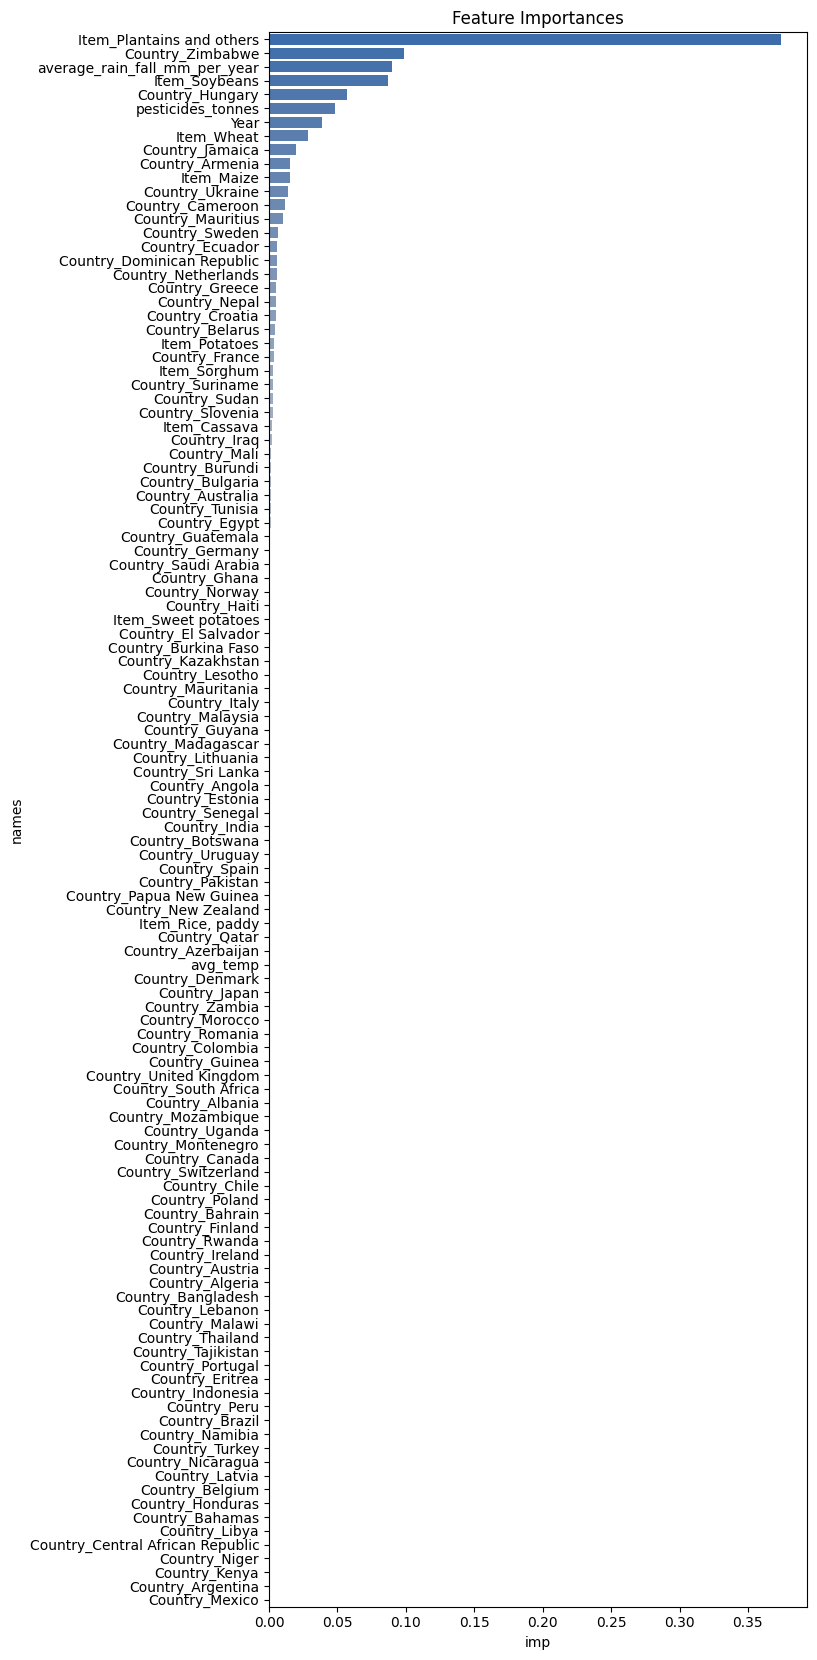

In [24]:
# Plot all feature importances
fig, ax = plt.subplots(figsize=(8.27, 16.7))
sns.barplot(x="imp", y="names", hue="names", palette="vlag", data=df, orient="h", ax=ax, legend=False)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

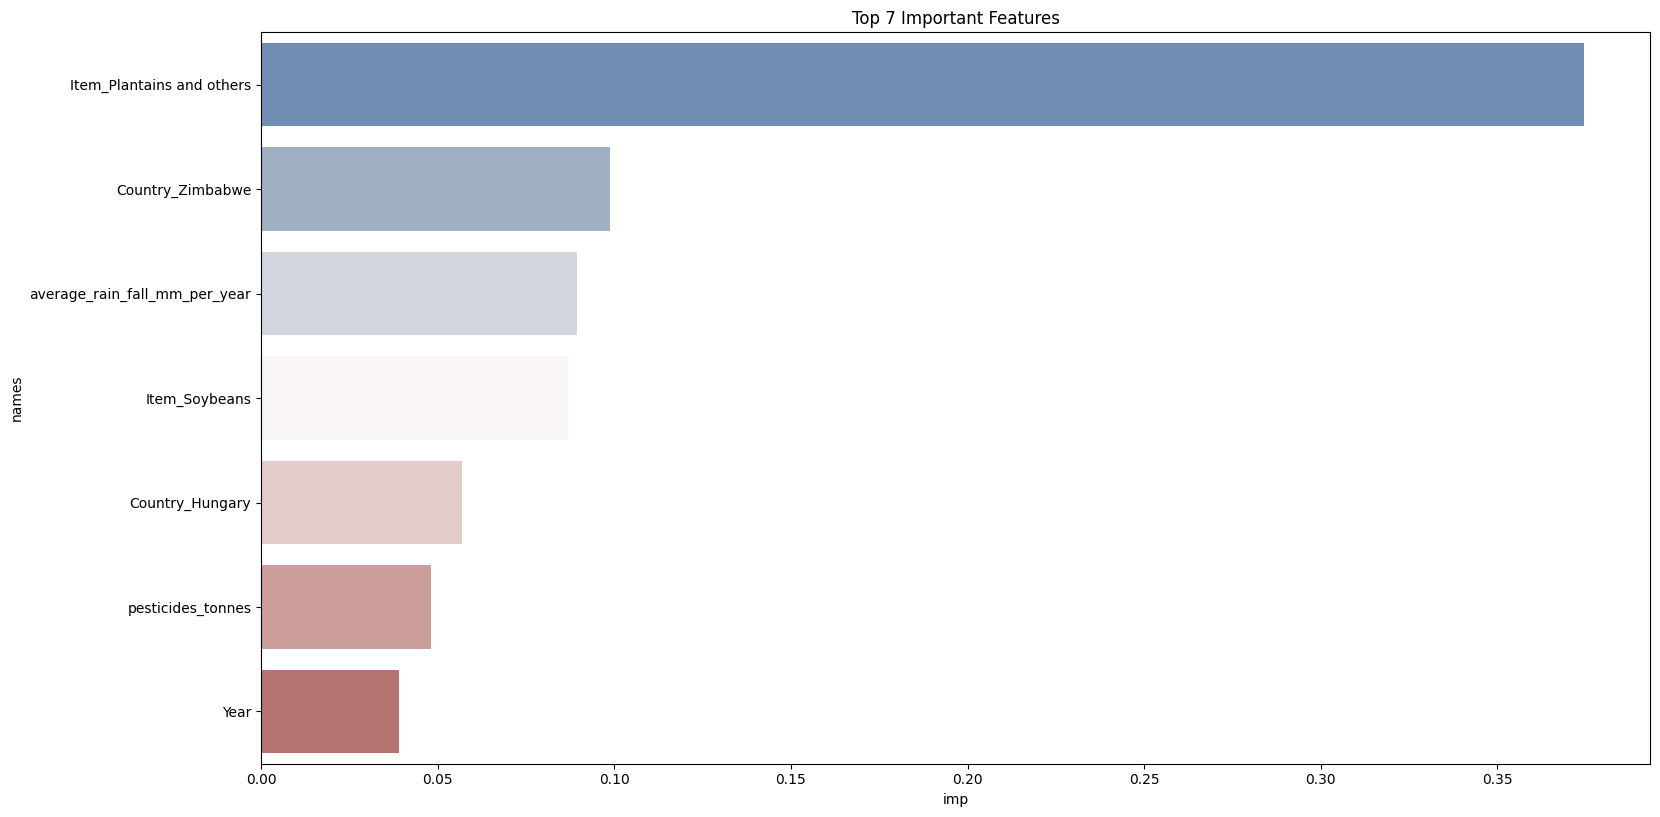

In [25]:
# Plot top 7 features
df_top7 = df.nlargest(7, 'imp')
if not df_top7.empty:
    fig, ax = plt.subplots(figsize=(16.7, 8.27))
    sns.barplot(x="imp", y="names", hue="names", palette="vlag", data=df_top7, orient="h", ax=ax, legend=False)
    plt.title("Top 7 Important Features")
    plt.tight_layout()
    plt.show()
else:
    print("Error: Not enough features for top 7 plot.")

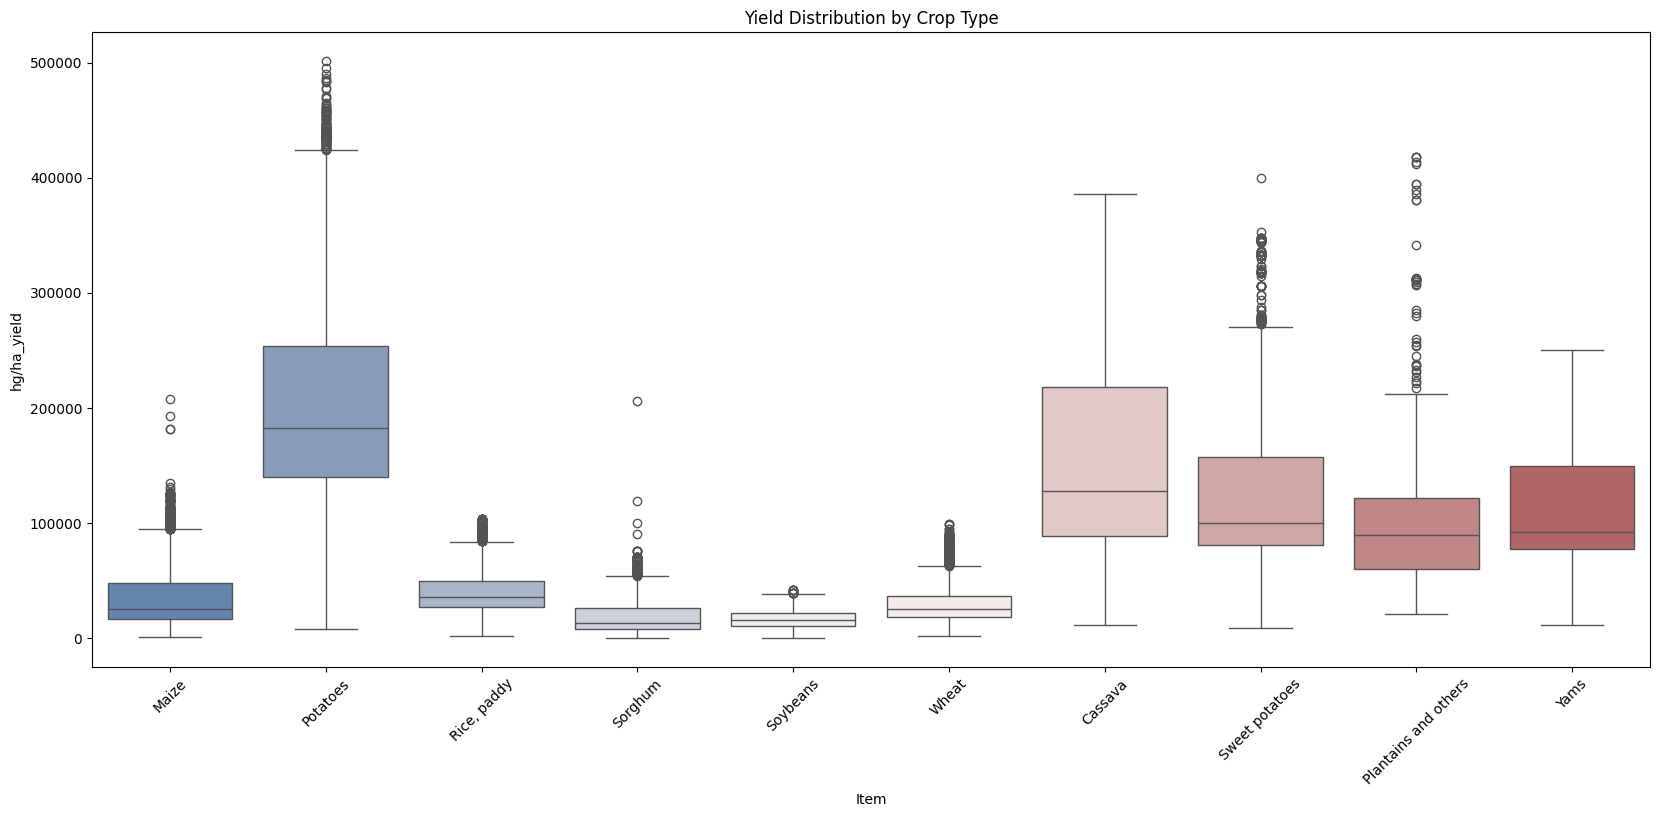

In [26]:
# Boxplot of yields by crop type
fig, ax = plt.subplots(figsize=(16.7, 8.27))
sns.boxplot(x="Item", y="hg/ha_yield", hue="Item", palette="vlag", data=yield_df, ax=ax, legend=False)
plt.title("Yield Distribution by Crop Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


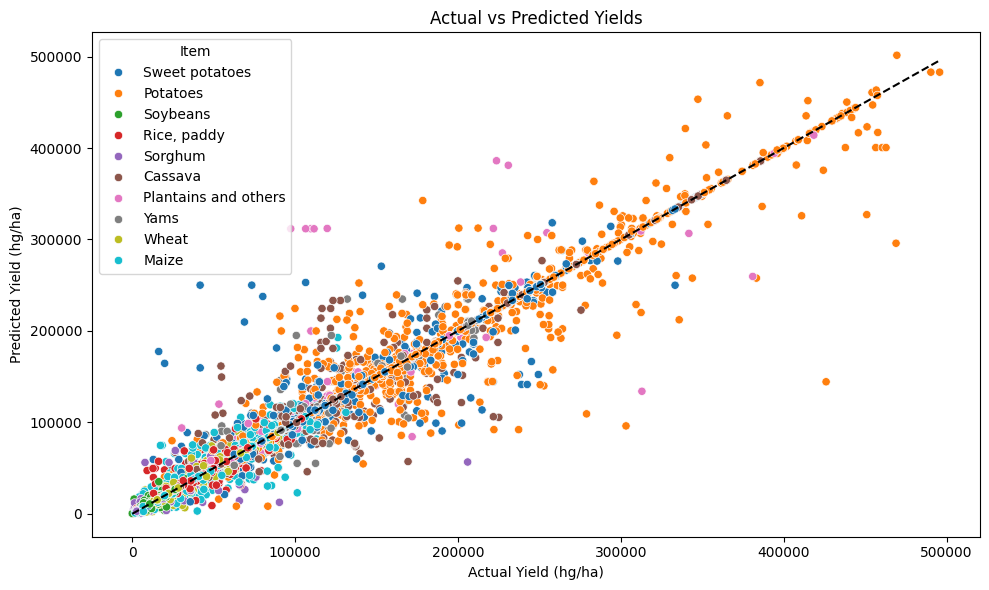

In [27]:
# Additional diagnostic plots
# Actual vs Predicted plot
if "Item" in test_df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="yield_actual", y="yield_predicted", hue="Item", data=test_df)
    plt.plot([test_df.yield_actual.min(), test_df.yield_actual.max()],
             [test_df.yield_actual.min(), test_df.yield_actual.max()], 'k--')
    plt.title("Actual vs Predicted Yields")
    plt.xlabel("Actual Yield (hg/ha)")
    plt.ylabel("Predicted Yield (hg/ha)")
    plt.tight_layout()
    plt.show()